In [13]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import time
import re

In [14]:
def get_url(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}
    r=requests.get(url, headers=headers)
    return r

def get_mof_data(page=0):
    if page==0:
        url='https://www.mof.gov.cn/gkml/caizhengshuju/index.htm'
    else:
        url=f'https://www.mof.gov.cn/gkml/caizhengshuju/index_{page}.htm'
    r=get_url(url)
    soup=BeautifulSoup(r.content)
    links=soup.find('div', {'class': 'mainboxerji'}).find_all('a')
    lst_links=[]
    domain=r'https://www.mof.gov.cn/gkml/caizhengshuju'
    for link in links:
        dict_link={}
        dict_link['title']=link.text
        if re.search(r'^\.\.(\/\.\.)?', link.get('href')):
            dict_link['link']=re.sub(r'^\.\.(\/\.\.)?', 'https://www.mof.gov.cn', 
                                     link.get('href'))
        else:
            dict_link['link']=re.sub(r'^\.', domain, link.get('href'))
        lst_links.append(dict_link)
    return lst_links

In [15]:
def get_links(pages):
    # get all the link from all pages
    links=[]
    for page in range(pages):
        links=links+get_mof_data(page)
    return links

In [16]:
def get_fin_text(url):
    time.sleep(2)
    r=get_url(url)
    soup=BeautifulSoup(r.content)
    content=soup.find('div', {'class': 'my_doccontent'})
    return content.text

In [17]:
def parse_income_text(content):
    dict_regex={
        '全国一般公共预算收入': r'全国一般公共预算收入([0-9\,\.]+亿)',
        '中央一般公共预算收入': r'中央一般公共预算收入([0-9\,\.]+亿)',
        '地方一般公共预算本级收入': r'地方一般公共预算本级收入([0-9\,\.]+亿)',
        '税收收入': r'税收收入([0-9\,\.]+亿)',
        '非税收入': r'非税收入([0-9\,\.]+亿)',
        '国内增值税': r'国内增值税([0-9\,\.]+亿)',
        '国内消费税': r'国内消费税([0-9\,\.]+亿)',
        '企业所得税': r'企业所得税([0-9\,\.]+亿)',
        '个人所得税': r'个人所得税([0-9\,\.]+亿)',
        '进口货物增值税消费税': r'进口货物增值税、消费税([0-9\,\.]+亿)',
        '关税': r'关税([0-9\,\.]+亿)',
        '出口退税': r'出口退税([0-9\,\.]+亿)',
        '城市维护建设税': r'城市维护建设税([0-9\,\.]+亿)',
        '车辆购置税': r'车辆购置税([0-9\,\.]+亿)',
        '印花税': r'印花税([0-9\,\.]+亿)',
        '资源税': r'资源税([0-9\,\.]+亿)',
        '契税': r'契税([0-9\,\.]+亿)',
        '房产税': r'房产税([0-9\,\.]+亿)',
        '城镇土地使用税': r'城镇土地使用税([0-9\,\.]+亿)',
        '土地增值税': r'土地增值税([0-9\,\.]+亿)',
        '耕地占用税': r'耕地占用税([0-9\,\.]+亿)',
        '环境保护税': r'环境保护税([0-9\,\.]+亿)',
        '其他各项税收收入': r'其他各项税收收入.*?([0-9\,\.]+亿)'
    }

    dict_result={}
    for key, regex in dict_regex.items():
        if re.search(regex, content):
            dict_result[key]=float(re.search(regex, content).group(1).replace('亿', ''))
        else:
            dict_result[key]=None

    return dict_result

In [6]:
links=get_links(9)
fin_link=[item for item in links if '收支' in item['title']]
contents=[get_fin_text(item['link']) for item in fin_link]
results=[parse_income_text(content) for content in contents]
index=[re.search(r'(.*?)财政收支情况', item['title']).group(1) for item in fin_link]

In [7]:
df=pd.DataFrame(results, index=index)
df.index=df.index.str.replace('上半年', '6月')\
    .str.replace('一季度', '3月').str.replace('前三季度', '9月')\
    .str.replace('1-2月', '2月').str.replace('年$', '年12月', regex=True)
df.index=pd.to_datetime(df.index, format='%Y年%m月')
df.head()

,全国一般公共预算收入,中央一般公共预算收入,地方一般公共预算本级收入,全国税收收入,非税收入,国内增值税,国内消费税,企业所得税,个人所得税,进口货物增值税消费税,...,车辆购置税,印花税,资源税,契税,房产税,城镇土地使用税,土地增值税,耕地占用税,环境保护税,其他各项税收收入
2024-08-01,147776.0,65361.0,82415.0,121059.0,26717.0,45936.0,11302.0,31385.0,9685.0,12621.0,...,1621.0,2233.0,1998.0,3558.0,2967.0,1603.0,3632.0,963.0,176.0,832.0
2024-07-01,135663.0,59745.0,75918.0,111240.0,24423.0,41303.0,10004.0,30702.0,8529.0,10966.0,...,1449.0,2120.0,1776.0,3169.0,2878.0,1562.0,3388.0,890.0,169.0,730.0
2024-06-01,115913.0,50011.0,65902.0,94080.0,21833.0,35400.0,8834.0,25384.0,7358.0,9297.0,...,1253.0,1632.0,1474.0,2779.0,2337.0,1298.0,3074.0,840.0,121.0,634.0
2024-05-01,96912.0,42778.0,54134.0,80462.0,16450.0,30119.0,7607.0,22382.0,6072.0,7741.0,...,1086.0,1505.0,1221.0,2326.0,2086.0,1120.0,2442.0,642.0,111.0,532.0
2024-04-01,80926.0,35250.0,45676.0,66938.0,13988.0,25787.0,6385.0,17898.0,5007.0,6134.0,...,898.0,1358.0,1011.0,1918.0,1822.0,965.0,2150.0,550.0,104.0,432.0


<Axes: >

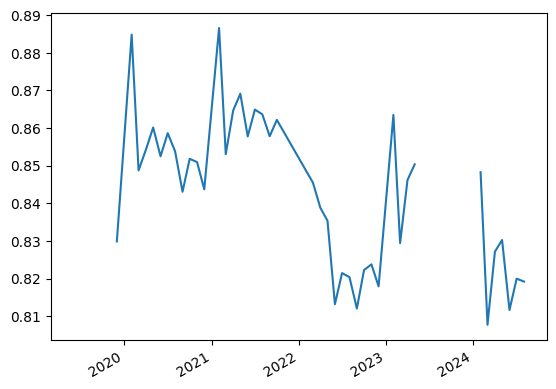

In [12]:
(df['全国税收收入']/df['全国一般公共预算收入']).plot()

In [60]:
df.apply(lambda row: row.sum(), axis=1)

2024-07-01    135481.0
2024-06-01    115655.0
2024-05-01     98891.0
2024-04-01     82359.0
2024-03-01     61853.0
2024-02-01     46121.0
2023-12-01    212782.0
2023-11-01    199599.0
2023-10-01    186576.0
2023-09-01    165588.0
2023-08-01    151479.0
2023-07-01    138455.0
2023-06-01    118305.0
2023-05-01     99768.0
2023-04-01     83201.0
2023-03-01     62150.0
2023-02-01     46013.0
2022-12-01    196270.0
2022-11-01    184450.0
2022-10-01    172284.0
2022-09-01    151955.0
2022-08-01    138321.0
2022-07-01    125487.0
2022-06-01    106023.0
2022-05-01     88286.0
2022-04-01     75186.0
2022-03-01     61621.0
2021-10-01    182008.0
2021-09-01    164130.0
2021-08-01    150485.0
2021-07-01    137617.0
2021-06-01    117045.0
2021-05-01     96227.0
2021-04-01     77260.0
2021-03-01     55569.0
2021-02-01     41129.0
2020-12-01    179003.0
2020-11-01    167479.0
2020-10-01    157441.0
2020-09-01    139608.0
2020-08-01    126624.0
2020-07-01    115032.0
2020-06-01     97105.0
2020-05-01 